In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',50)
pd.options.mode.chained_assignment = None

import random
random.seed(68)

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=20)

from rdkit import Chem

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from standardization_process import plot_reg_correlation,plot_diagram,unreliable_datapoints,final_mean_value,identify_unreliable_group,plot_cls_correlation,plot_classification_diagram

In [3]:
def remove_bad_datapoints(df,controlled_list,value_col,fold=np.log10(3)):
    bad_datapoints_index = unreliable_datapoints(df, controlled_list, value_col)
    df = df.loc[~df.index.isin(bad_datapoints_index),] 
    
    bad_group_index = identify_unreliable_group(df, controlled_list, value_col, fold=fold)
    
    df = df.loc[~df.index.isin(bad_group_index),] 
    return df

In [4]:
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
from data_split import train_test_split
def compound_property_analysis(mol_list):
    atom_counts = mol_list.map(lambda x: x.GetNumAtoms())
    qed = mol_list.parallel_apply(Descriptors.qed)
    logp = mol_list.parallel_apply(Descriptors.MolLogP)
    TPSA = mol_list.parallel_apply(Descriptors.TPSA)
    HBD = mol_list.parallel_apply(Descriptors.NumHDonors)
    HBA = mol_list.parallel_apply(Descriptors.NumHAcceptors)
    
    fig, axs = plt.subplots(3,2, figsize=(16, 10))

    # Plot data
    axs[0, 0].hist(qed, bins=20, color='b', alpha=0.7, label='A')
    axs[0, 0].set_title('qed')

    axs[0, 1].hist(atom_counts, bins=20, color='r', alpha=0.7, label='B')
    axs[0, 1].set_title('atom_counts')

    axs[1, 0].hist(logp, bins=20, color='g', alpha=0.7, label='C')
    axs[1, 0].set_title('logp')

    axs[1, 1].hist(TPSA, bins=20, color='y', alpha=0.7, label='D')
    axs[1, 1].set_title('TPSA')

    axs[2, 0].hist(HBD, bins=20, color='y', alpha=0.7, label='D')
    axs[2, 0].set_title('HBD')

    axs[2, 1].hist(HBA, bins=20, color='y', alpha=0.7, label='D')
    axs[2, 1].set_title('HBA')

    # Add some labels and titles for better readability
    for ax in axs.flat:
        ax.set( ylabel='Frequency')


    plt.show()

# Load data

In [5]:
all_data = pd.read_csv('../data/data_processing_result/bbb_preprocessing_finished.csv')

In [6]:
all_data.head()

,Smiles_unify,Smiles,value,source,property
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,0,B3DB,bbb
1,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,0,B3DB,bbb
2,Oc1c(I)cc(Cl)c2cccnc12,Oc1c(I)cc(Cl)c2cccnc12,0,B3DB,bbb
3,CCNC(=NCCSCc1ncccc1Br)NC#N,CCNC(=NCCSCc1ncccc1Br)NC#N,0,B3DB,bbb
4,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,0,B3DB,bbb


<AxesSubplot:>

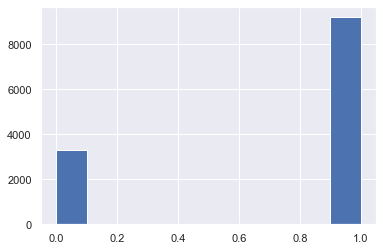

In [7]:
all_data['value'].hist()

### Dataset correlation

In [8]:
all_data['source'].value_counts()

B3DB             7805
TDC_martin       2039
TDC_adenot       1581
CHEMBL4408525      34
CHEMBL4198351      33
                 ... 
CHEMBL5133683       2
CHEMBL4669395       2
CHEMBL4686703       1
CHEMBL5128450       1
CHEMBL4724699       1
Name: source, Length: 92, dtype: int64

In [9]:
def merge_sources(x):
    if x == 'B3DB':
        return x
    elif 'TDC' in x:
        return x
    else:
        return 'Chembl'

all_data['source1'] = all_data['source'].apply(merge_sources)

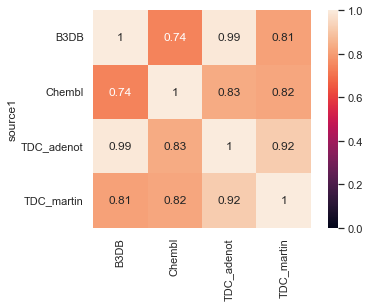

In [10]:
# tmp = all_data.drop_duplicates(['Smiles_unify','source1'])
plot_cls_correlation(all_data, ['Smiles_unify'], 'source1', 'value', fig_title='datasets correlation')

# Further filtering

In [11]:
smi_cols = 'Smiles_unify'
source_col = 'source1'
value_col = 'value'

In [12]:
df_pivot = pd.pivot_table(data=all_data, index=smi_cols, columns=source_col, values=value_col)

In [13]:
df_pivot

source1,B3DB,Chembl,TDC_adenot,TDC_martin
Smiles_unify,,,,
BrC(Br)Br,1.0,NaN,1.0,1.0
Brc1c(NC2=NCCN2)ccc2nccnc12,1.0,NaN,NaN,NaN
Brc1cc(Br)c(NC2=NCCN2)c(Br)c1,1.0,NaN,NaN,NaN
Brc1ccc(-c2nnc(N3CCN(c4ccccn4)CC3)o2)cc1,NaN,1.0,NaN,NaN
Brc1ccc(CNC2CCN(Cc3ccccc3)C2)cc1,NaN,1.0,NaN,NaN
...,...,...,...,...
c1cncc(C2CCCN2)c1,1.0,NaN,NaN,NaN
c1cncc(CC2(Cc3ccncc3)c3cccnc3-c3ncccc32)c1,1.0,NaN,NaN,1.0
c1cncc([C@@H]2CCCN2)c1,1.0,NaN,NaN,NaN


In [14]:
remove_none = pd.DataFrame()
def filter_bbb(x):
    if x.nunique()==1:
        if x.dropna().unique() in [0,1]:
            return x.dropna().unique()[0]
        else:
            return None
    else:
        return None
    
remove_none['value'] = df_pivot.apply(filter_bbb,axis=1)
remove_none.reset_index(inplace=True)

In [15]:
remove_none = remove_none[~remove_none['value'].isna()]

In [16]:
remove_none['property'] = 'bbb'

In [18]:
df = remove_none[['Smiles_unify','value','property']]

# Compound Property analysis

In [19]:
mol_list = df['Smiles_unify'].map(Chem.MolFromSmiles)

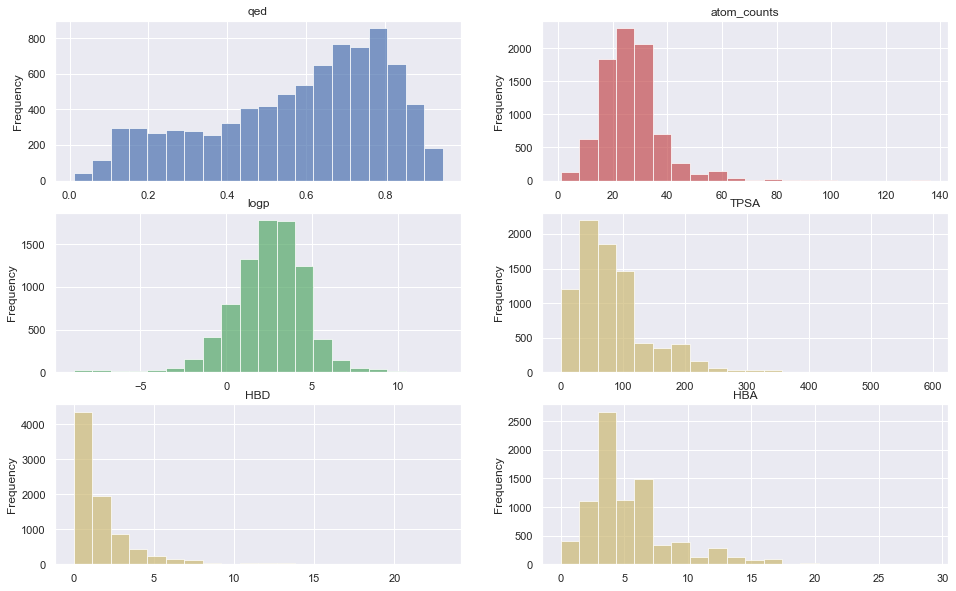

In [20]:
compound_property_analysis(mol_list)

# Data Split

In [24]:
df =  df.reset_index()

In [25]:
train_index,test_index = train_test_split(df['Smiles_unify'].map(Chem.MolFromSmiles),split_scaffold=True)
df.loc[train_index,'scaffold_train_test_label'] = 'train'
df.loc[test_index,'scaffold_train_test_label'] = 'test'

100%|█████████████████████████████████████████| 8301/8301 [00:01<00:00, 4378.93it/s]


In [26]:
train_index,test_index = train_test_split(df['Smiles_unify'].map(Chem.MolFromSmiles),split_scaffold=False)
df.loc[train_index,'random_train_test_label'] = 'train'
df.loc[test_index,'random_train_test_label'] = 'test'

100%|████████████████████████████████████████| 8301/8301 [00:00<00:00, 11158.82it/s]


In [27]:
df

,index,Smiles_unify,value,property,scaffold_train_test_label,random_train_test_label
0,0,BrC(Br)Br,1.0,bbb,train,train
1,1,Brc1c(NC2=NCCN2)ccc2nccnc12,1.0,bbb,train,train
2,2,Brc1cc(Br)c(NC2=NCCN2)c(Br)c1,1.0,bbb,train,test
3,3,Brc1ccc(-c2nnc(N3CCN(c4ccccn4)CC3)o2)cc1,1.0,bbb,test,train
4,4,Brc1ccc(CNC2CCN(Cc3ccccc3)C2)cc1,1.0,bbb,test,train
...,...,...,...,...,...,...
8296,8649,c1cncc(C2CCCN2)c1,1.0,bbb,test,test
8297,8650,c1cncc(CC2(Cc3ccncc3)c3cccnc3-c3ncccc32)c1,1.0,bbb,train,train
8298,8651,c1cncc([C@@H]2CCCN2)c1,1.0,bbb,train,train
8299,8652,c1csc(Cc2ccccc2OCC2CNCCO2)c1,1.0,bbb,train,train


In [28]:
df.to_csv('../data/final_datasets/bbb_cls_final_data.csv',index=False)